In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
# set number of assets (= number of qubits)
num_assets = 5
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

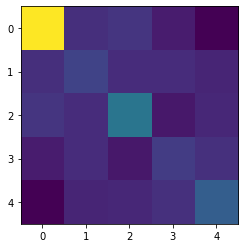

In [3]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [4]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.015284386652 x_0 + 0.000780952145 x_1 - 0.000517920547 x_2
      - 0.000870005837 x_3 - 0.010323519990 x_4 + [ 0.002541388592 x_0^2
      + 0.000146804433 x_0*x_1 + 0.000257201062 x_0*x_2 - 0.000199722426 x_0*x_3
      - 0.000626398406 x_0*x_4 + 0.000258486713 x_1^2 + 0.000106085519 x_1*x_2
      + 0.000088963242 x_1*x_3 - 0.000026490315 x_1*x_4 + 0.000791504681 x_2^2
      - 0.000247774763 x_2*x_3 - 0.000001940547 x_2*x_4 + 0.000197892585 x_3^2
      + 0.000170306704 x_3*x_4 + 0.000543294856 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

In [27]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [28]:
%%time
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.8670
 [0 0 1 1]	-0.0010		0.1054
 [1 1 0 0]	-0.0130		0.0214
 [1 0 1 0]	-0.0140		0.0042
 [0 1 0 1]	0.0002		0.0013
 [0 1 1 0]	0.0008		0.0006
 [0 0 1 0]	1.0197		0.0001
 [1 1 1 0]	1.0069		0.0001
 [0 1 1 1]	1.0199		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 0 0]	4.0795		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 1 1 1]	4.0656		0.0000
CPU times: user 1.38 s, sys: 81.6 ms, total: 1.46 s
Wall time: 1.51 s


In [29]:
%%time
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.1683
 [1 0 1 0]	-0.0140		0.1682
 [1 1 0 0]	-0.0130		0.1679
 [0 0 1 1]	-0.0010		0.1653
 [0 1 0 1]	0.0002		0.1652
 [0 1 1 0]	0.0008		0.1650
 [1 1 1 1]	4.0656		0.0000
 [0 0 0 0]	4.0795		0.0000
 [1 0 1 1]	1.0049		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 1 1 0]	1.0069		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 1 0]	1.0197		0.0000
 [0 0 0 1]	1.0191		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 0 0]	1.0059		0.0000
CPU times: user 633 ms, sys: 23.1 ms, total: 656 ms
Wall time: 656 ms
